In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/CV8160 S24/Module6'

/content/drive/MyDrive/CV8160 S24/Module6


In [46]:
import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
!gdown 'https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN'
!gdown 'https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i'

Downloading...
From: https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN
To: /content/drive/MyDrive/CV8160 S24/Module6/train.zip
100% 8.67M/8.67M [00:00<00:00, 72.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i
To: /content/drive/MyDrive/CV8160 S24/Module6/test.zip
100% 459k/459k [00:00<00:00, 58.8MB/s]


In [5]:
!ls

AR_EDIT.ipynb  delay_bottleneck.csv  __MACOSX	  RNN_Scratch.ipynb  tps_df.pkl
armodel.pt     GRU_LSTM.ipynb	     models.py	  test_data	     train.zip
data	       grumodel.pt	     __pycache__  test.zip	     utils


In [12]:
!unzip 'train.zip' -d '.'
!unzip 'test.zip' -d '.'

Archive:  train.zip
replace ./tps_df.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./tps_df.pkl            
  inflating: ./__MACOSX/._tps_df.pkl  
Archive:  test.zip
  inflating: ./test_data/tps_5.pkl   
  inflating: ./test_data/tps_2.pkl   
  inflating: ./test_data/tps_6.pkl   
  inflating: ./test_data/tps_4.pkl   
  inflating: ./test_data/tps_15.pkl  
  inflating: ./test_data/tps_7.pkl   
  inflating: ./test_data/tps_1.pkl   
  inflating: ./test_data/tps_12.pkl  
  inflating: ./test_data/tps_8.pkl   
  inflating: ./test_data/tps_3.pkl   
  inflating: ./test_data/tps_9.pkl   
  inflating: ./test_data/tps_13.pkl  
  inflating: ./test_data/tps_11.pkl  
  inflating: ./test_data/tps_10.pkl  
  inflating: ./test_data/tps_14.pkl  


compare LSTM to GRU window = 10,36 horizon = 36

In [66]:
class TrafficForecast(Dataset):
    def __init__(self,pkl_path, window, horizon, task='train'):
        self.pkl_path = pkl_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.X = []
        self.y = []


        df = pd.read_pickle(self.pkl_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)

        self.seg_ids = self.df['segmentID'].unique()
        self.setup_forecast()

        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=10)


        if task == 'train':
            self.inputs = X_train
            self.targets = y_train
        if task == 'test':
            self.inputs = X_test
            self.targets = y_test

    def setup_forecast(self):
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill")
            TI_series = df_seg_id['TrafficIndex_GP'].values
            h_series = df_seg_id['hour'].values
            #split 80 train 20 test
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                x = TI_series[t:t+self.window]
                # h = h_series[t:t+self.window]
                # x_cat = np.dstack([x,h])
                y = TI_series[t+self.window:(t+self.window+self.horizon)]

                self.X.append(x)
                self.y.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window,1)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}


In [67]:
tobj_train = TrafficForecast('tps_df.pkl',10,36,'train')
tobj_test = TrafficForecast('tps_df.pkl',10,36,'test')

<ipython-input-66-c62010e248e3>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_seg_id = df_seg_id.fillna(method="ffill")
<ipython-input-66-c62010e248e3>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_seg_id = df_seg_id.fillna(method="ffill")


In [68]:
tobj.inputs[0].shape

(1, 36, 2)

In [70]:
bs = 1024
dataloader_train = DataLoader(tobj_train, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
dataloader_test = DataLoader(tobj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

In [71]:
for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx==3:
        break

for idx, data in enumerate(dataloader_test):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx==3:
        break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>AssertionError
: can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])
torch.Size([1024, 10, 1]) torch.Size([1024, 36])


In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
from models import MyLSTM, MyGRU

In [73]:

model = MyLSTM(n_inputs=1, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  mean_loss.append(np.mean(losses))
  mean_test_loss.append(np.mean(test_losses))
  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050><function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._pa

Epoch 1/3, Training Loss: 0.0687


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 2/3, Training Loss: 0.0397


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>    self._shutdown_workers()
Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__


    Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        
assert self._parent_pid == os.getpid(

Epoch 3/3, Training Loss: 0.0298


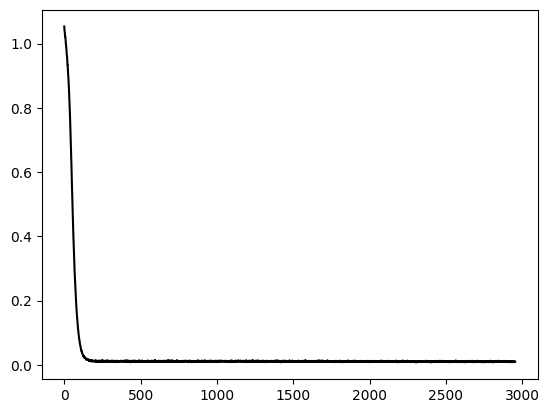

In [75]:
plt.plot(losses,'k',label='training')


In [76]:
torch.save(model.state_dict(), 'grumodel.pt')

In [82]:
# model_arch = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
# model_arch.load_state_dict(torch.load('grumodel.pt'))
model.eval()

MyLSTM(
  (relu): ReLU()
  (rnn): LSTM(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=36, bias=True)
)

In [83]:
def evaluation(model_arch,dataloader_test):
    model_arch.to(device)
    rmse = []
    maes = []
    for i_test,sample_test in enumerate(dataloader_test):
        preds = model_arch(sample_test['inputs'].to(device))
        targets = sample_test['outputs'].to(device)
        error = ((preds-targets)**2).sum(1).mean().detach().cpu().numpy()
        mae = (preds-targets).abs().sum(1).mean().detach().cpu().numpy()
        rmse.append(math.sqrt(error))
        maes.append(mae)
    return {'rmse':np.mean(rmse),'mae':np.mean(maes)}

In [84]:
eval_volhour = evaluation(model, dataloader_test)
print(f"Volume and Hour RMSE: {eval_volhour['rmse']}, MAE: {eval_volhour['mae']}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x782540b9e050>
if w.is_alive():Traceback (most recent call last):
  File "/u

Volume and Hour RMSE: 0.5945986167331798, MAE: 1.5789815187454224
